# Creating a model to Predict Student Mental Health

In [1]:
#IMPORTS
import kagglehub
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight

### The Objective
Mental health is of course something often neglected by the average person. The primary objective of this study is to predict which demographics of students are most at risk of suffering from mental illness. This prediction aims to identify vulnerable student populations early, enabling universities to allocate mental health resources effectively and provide timely support. By targeting groups at higher risk, universities can proactively address the mental well-being of students, fostering a healthier academic environment and improving overall student outcomes.<br>

This prediction is particularly significant because mental health challenges can negatively impact academic performance, personal development, and future opportunities. By leveraging demographic data (e.g., gender, year of study, and course), academic factors (e.g., GPA and study hours), and engagement metrics, this analysis can help identify critical factors contributing to mental illness among students.<br>

Based on initial observations, certain courses appear to place greater academic pressure on students, leading to struggles with maintaining a high GPA. Combined with limited mental health support, this could exacerbate stress, anxiety, and other mental health issues. By uncovering these patterns, this study seeks to highlight the intersection between course demands, GPA performance, and mental health, providing actionable insights for intervention.<br>

### Data Wrangling and Cleaning
To approach this predictive model, I've taken data from Kaggle outlining a Mental Health Survey conducted at a university in Malaysia. This survey data was idealized as it contained both demographic information, school/course information, and mental health information -- detailing exactly what I wanted to research on. The data was cleaned up to further emphasize the data I was exploring, course names were altered to be more univerisally understood, and of course, null data was dropped.

In [2]:
#Download latest version
path = kagglehub.dataset_download("junnn0126/university-students-mental-health")

#Assign to Dataframe
df = pd.read_csv(r'C:\Users\Rahul\OneDrive\Documents\College\Senior Year\Fall 2024\DAT 402\Project 2\data\mentalhealth_dataset.csv')

#Clean Data
#Drop columns as they're irrelevant to to objective
df.drop('Timestamp', axis=1, inplace=True)
df.drop('SymptomFrequency_Last7Days', axis=1, inplace=True)

#Drop the word "Year" and make numeric
df['YearOfStudy'] = df['YearOfStudy'].str.replace('Year', '').str.strip()
df['YearOfStudy'] = df['YearOfStudy'].str.replace('year', '').str.strip()
df['YearOfStudy'] = pd.to_numeric(df['YearOfStudy'])

#Change course names with inconsistencies
df['Course'] = df['Course'].str.replace('Benl', 'BENL').str.strip()
df['Course'] = df['Course'].str.replace('engin', 'Engineering').str.strip()
df['Course'] = df['Course'].apply(lambda x: 'Engineering' if x.strip() == 'Engine' else x)
df['Course'] = df['Course'].str.replace('Fiqh fatwa', 'Religious Studies').str.strip()
df['Course'] = df['Course'].str.replace('Fiqh', 'Religious Studies').str.strip()
df['Course'] = df['Course'].str.replace('Irkhs', 'Religious Studies').str.strip()
df['Course'] = df['Course'].str.replace('Pendidikan Islam', 'Religious Studies').str.strip()
df['Course'] = df['Course'].str.replace('Pendidikan islam', 'Religious Studies').str.strip()
df['Course'] = df['Course'].str.replace('Kirkhs', 'Religious Studies').str.strip()
df['Course'] = df['Course'].str.replace('KIRKHS', 'Religious Studies').str.strip()
df['Course'] = df['Course'].str.replace('Islamic Education', 'Religious Studies').str.strip()
df['Course'] = df['Course'].str.replace('Islamic education', 'Religious Studies').str.strip()
df['Course'] = df['Course'].str.replace('Usuluddin', 'Religious Studies').str.strip()
df['Course'] = df['Course'].str.replace('BCS', 'Computer Science').str.strip()
df['Course'] = df['Course'].str.replace('BIT', 'IT').str.strip()
df['Course'] = df['Course'].str.replace('Econs', 'Economics').str.strip()
df['Course'] = df['Course'].str.replace('KENMS', 'Economics').str.strip()
df['Course'] = df['Course'].str.replace('Koe', 'Engineering').str.strip()
df['Course'] = df['Course'].str.replace('koe', 'Engineering').str.strip()
df['Course'] = df['Course'].str.replace('KOE', 'Engineering').str.strip()
df['Course'] = df['Course'].str.replace('Kop', 'Pharmacy').str.strip()
df['Course'] = df['Course'].str.replace('MHSC', 'Health Studies').str.strip()
df['Course'] = df['Course'].str.replace('psychology', 'Pychology').str.strip()
df['Course'] = df['Course'].str.replace('TAASL', 'Education').str.strip()
df['Course'] = df['Course'].str.replace('ENM', 'Mathematics').str.strip()
df['Course'] = df['Course'].str.replace('Diploma Nursing', 'Nursing').str.strip()
df['Course'] = df['Course'].str.replace('DIPLOMA TESL', 'English (Second Language)').str.strip()
df['Course'] = df['Course'].str.replace('BENL', 'Human Sciences').str.strip()



#Make Column names more "readable"
df.rename(columns={'StudyStressLevel': 'Stress'}, inplace=True)
df.rename(columns={'SpecialistTreatment': 'Therapy'}, inplace=True)
df.rename(columns={'CGPA': 'GPA'}, inplace=True)

#Drop Null Data
df = df.dropna() 
if (df.isnull().sum()).any == False: #check if null data persists
    print("Null Data Exists")

print("Total Number of Observations: ", len(df)) #Observations > 500?
df.head() #What does the df look like after cleaning?

Total Number of Observations:  1000


,Gender,Age,Course,YearOfStudy,GPA,Depression,Anxiety,PanicAttack,Therapy,HasMentalHealthSupport,SleepQuality,Stress,StudyHoursPerWeek,AcademicEngagement
0,Female,24,Biotechnology,3,2.38,1,0,0,0,0,4,5,8,2
1,Female,18,Biotechnology,3,4.00,0,1,0,0,0,4,4,13,5
2,Female,25,Biotechnology,3,3.68,0,0,1,0,0,1,2,13,1
3,Female,18,Engineering,4,4.00,0,0,0,0,0,5,1,19,2
4,Female,20,Engineering,4,2.00,1,1,0,0,0,2,4,3,2


### Exploratory Data Analysis and Interesting Features
I decided the best approach was to divide our data based on whether it contained information pertaining to Mental Health data or demographic data. Then thought it best to see how they correlate with one another with the help of a correlation matrix.

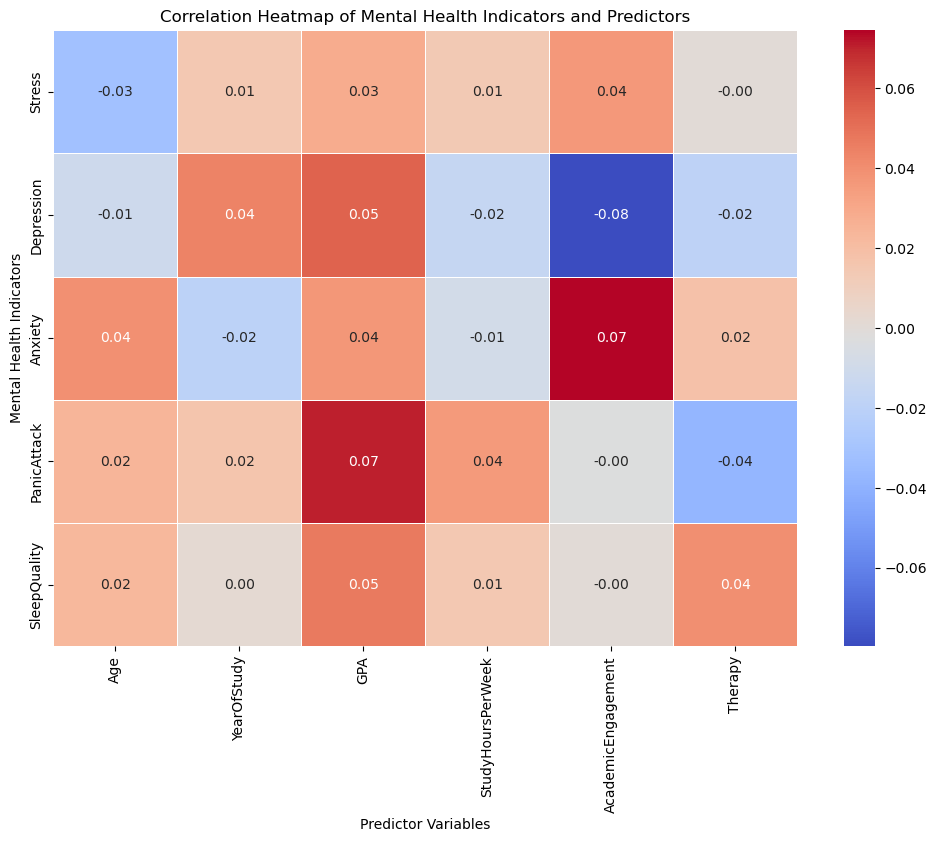

In [3]:
mental_health_columns = ['Stress', 'Depression', 'Anxiety', 'PanicAttack', 'SleepQuality']
predictor_columns = ['Age', 'YearOfStudy', 'GPA', 'StudyHoursPerWeek', 'AcademicEngagement', 'Therapy']

correlation_matrix = df[mental_health_columns + predictor_columns].corr()
correlation_subset = correlation_matrix.loc[mental_health_columns, predictor_columns]

#Plot CM
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_subset, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Mental Health Indicators and Predictors')
plt.xlabel('Predictor Variables')
plt.ylabel('Mental Health Indicators')
plt.show()

What I found most interesting and shocking was how higher GPA's correlated best with students identifying with Panic Disorder. Furthermore, students that engaged the most in class (i.e. attendance or an overall care for their coursework) feel the most pressure and anxiety but also felt the least depressed. I was relieved to see the positive impact that therapy had -- students that were in therapy reported better sleep, less depressive thoughts, and less anxiety. It also seemed apparent that students navigated toward therapy more in their Junior and Senior Years. <br>
I wanted to further let my curiosity flourish by diving deeper into the features that mattered most to this report's objective -- does school genuinely impact mental health? I designed some boxplots to show how GPA, Study Hours Per Week, and Academic Engagement were affected by (or affected) Student Mental Health.

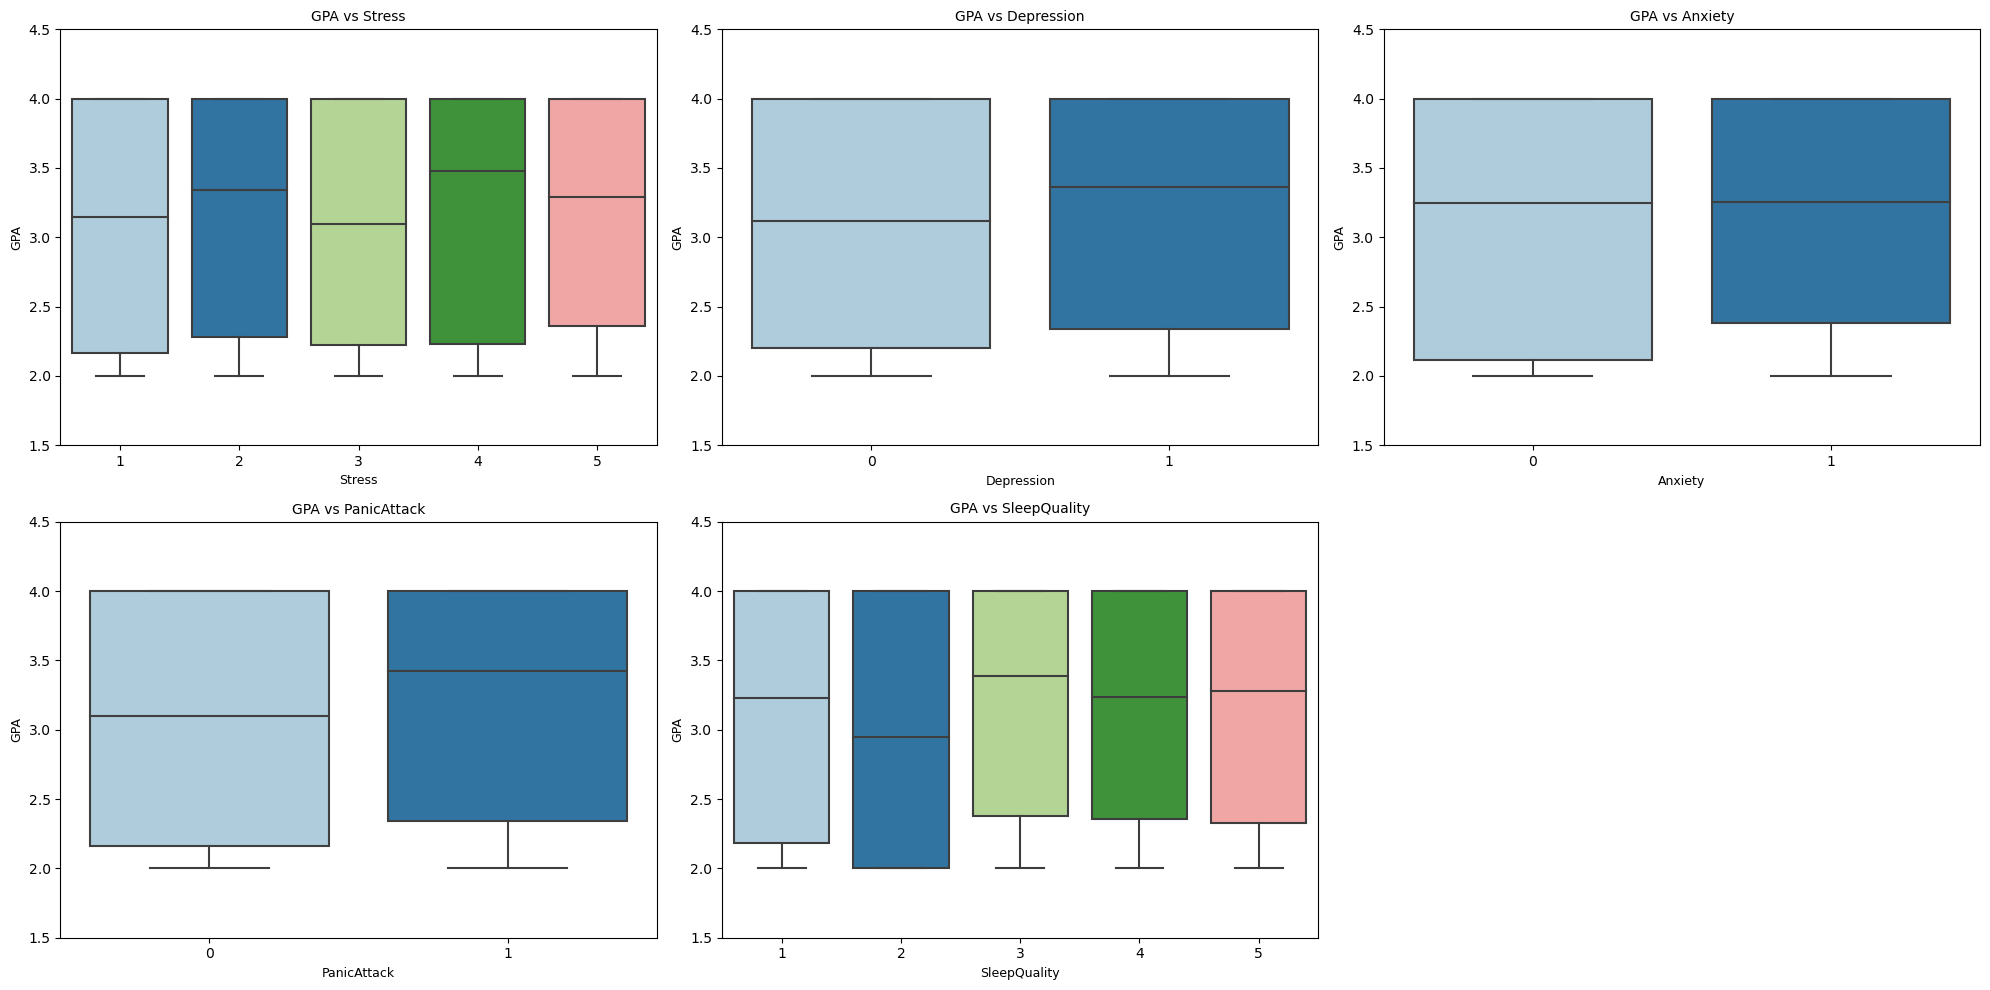

In [4]:
num_cols = 3
plt.figure(figsize=(20, 10))
for i, column in enumerate(mental_health_columns):
    plt.subplot(len(mental_health_columns) // num_cols + 1, num_cols, i + 1)
    sns.boxplot(data=df, x=column, y='GPA', palette='Paired')
    plt.title(f'GPA vs {column}', fontsize=10)
    plt.xlabel(column, fontsize=9)
    plt.ylabel('GPA', fontsize=9)
    plt.ylim(df['GPA'].min() - 0.5, df['GPA'].max() + 0.5)
plt.tight_layout()
plt.show()

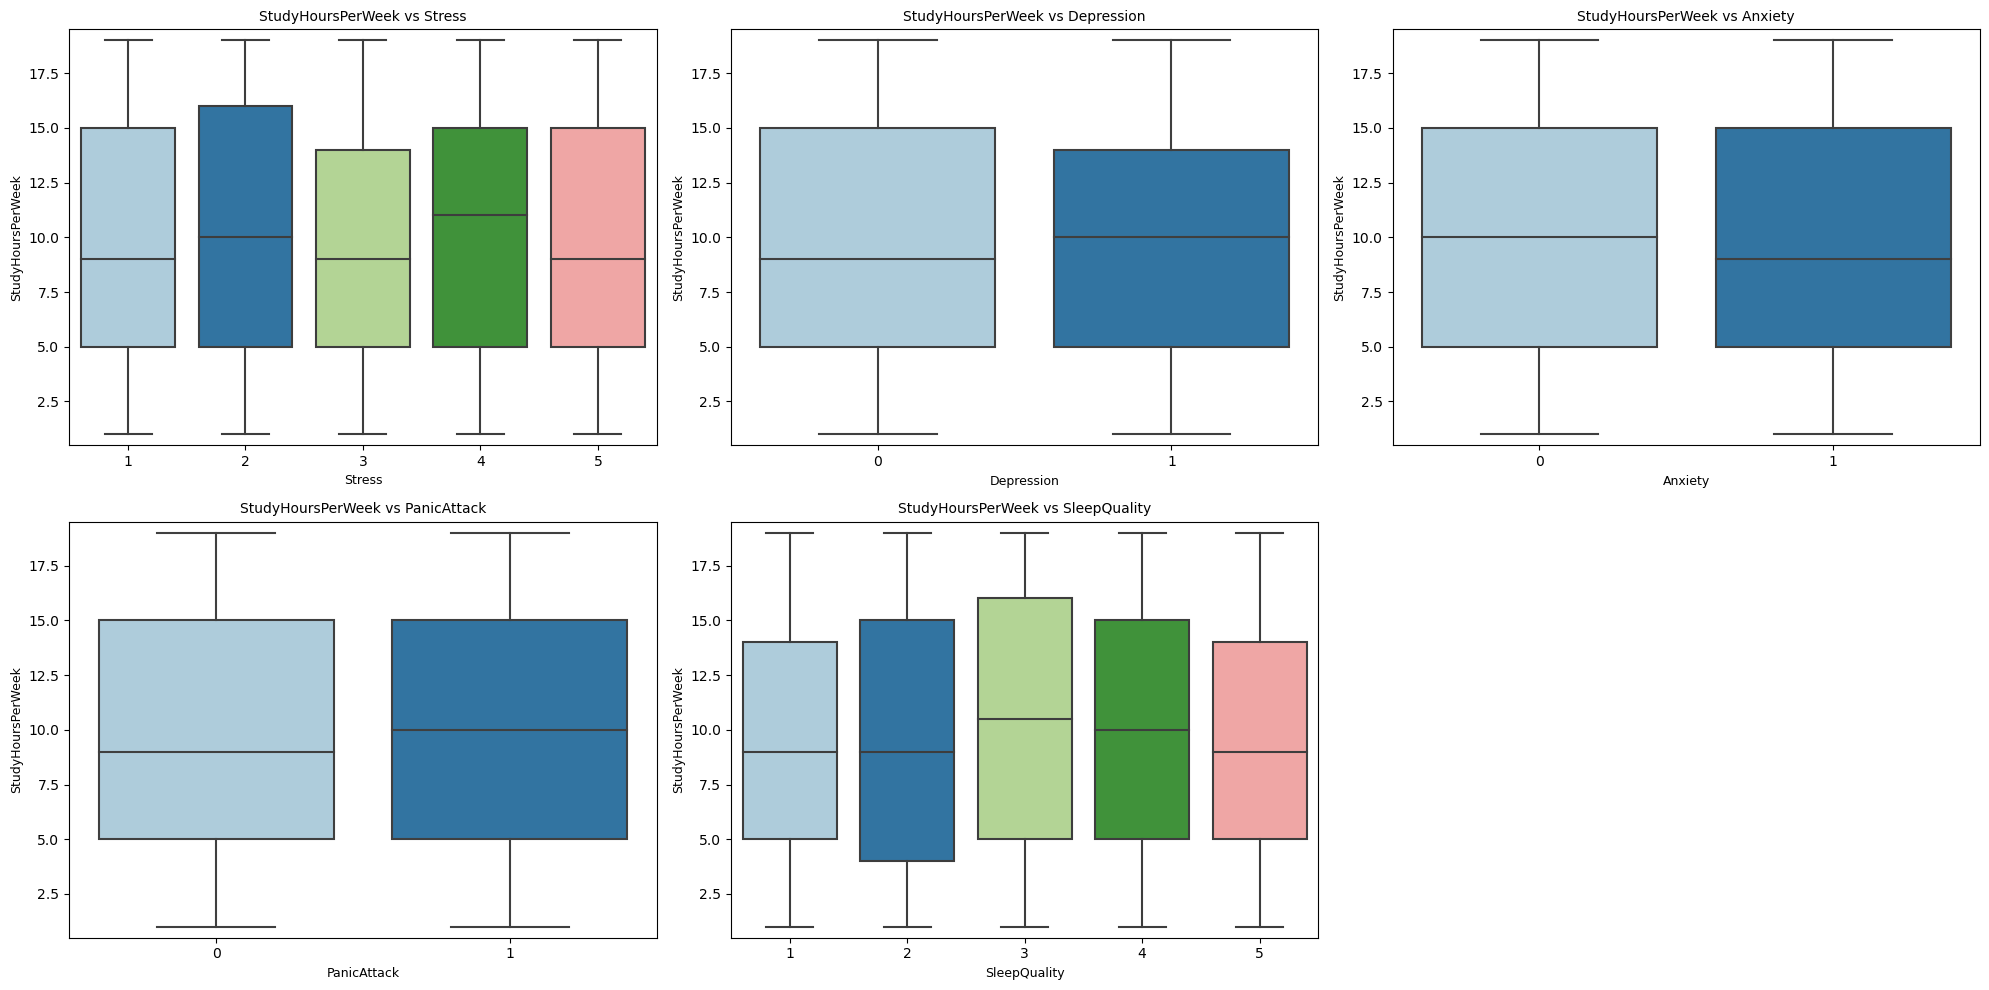

In [5]:
plt.figure(figsize=(20, 10))
for i, column in enumerate(mental_health_columns):
    plt.subplot(len(mental_health_columns) // num_cols + 1, num_cols, i + 1)
    sns.boxplot(data=df, x=column, y='StudyHoursPerWeek', palette='Paired')
    plt.title(f'StudyHoursPerWeek vs {column}', fontsize=10)
    plt.xlabel(column, fontsize=9)
    plt.ylabel('StudyHoursPerWeek', fontsize=9)
    plt.ylim(df['StudyHoursPerWeek'].min() - 0.5, df['StudyHoursPerWeek'].max() + 0.5)
plt.tight_layout()
plt.show()

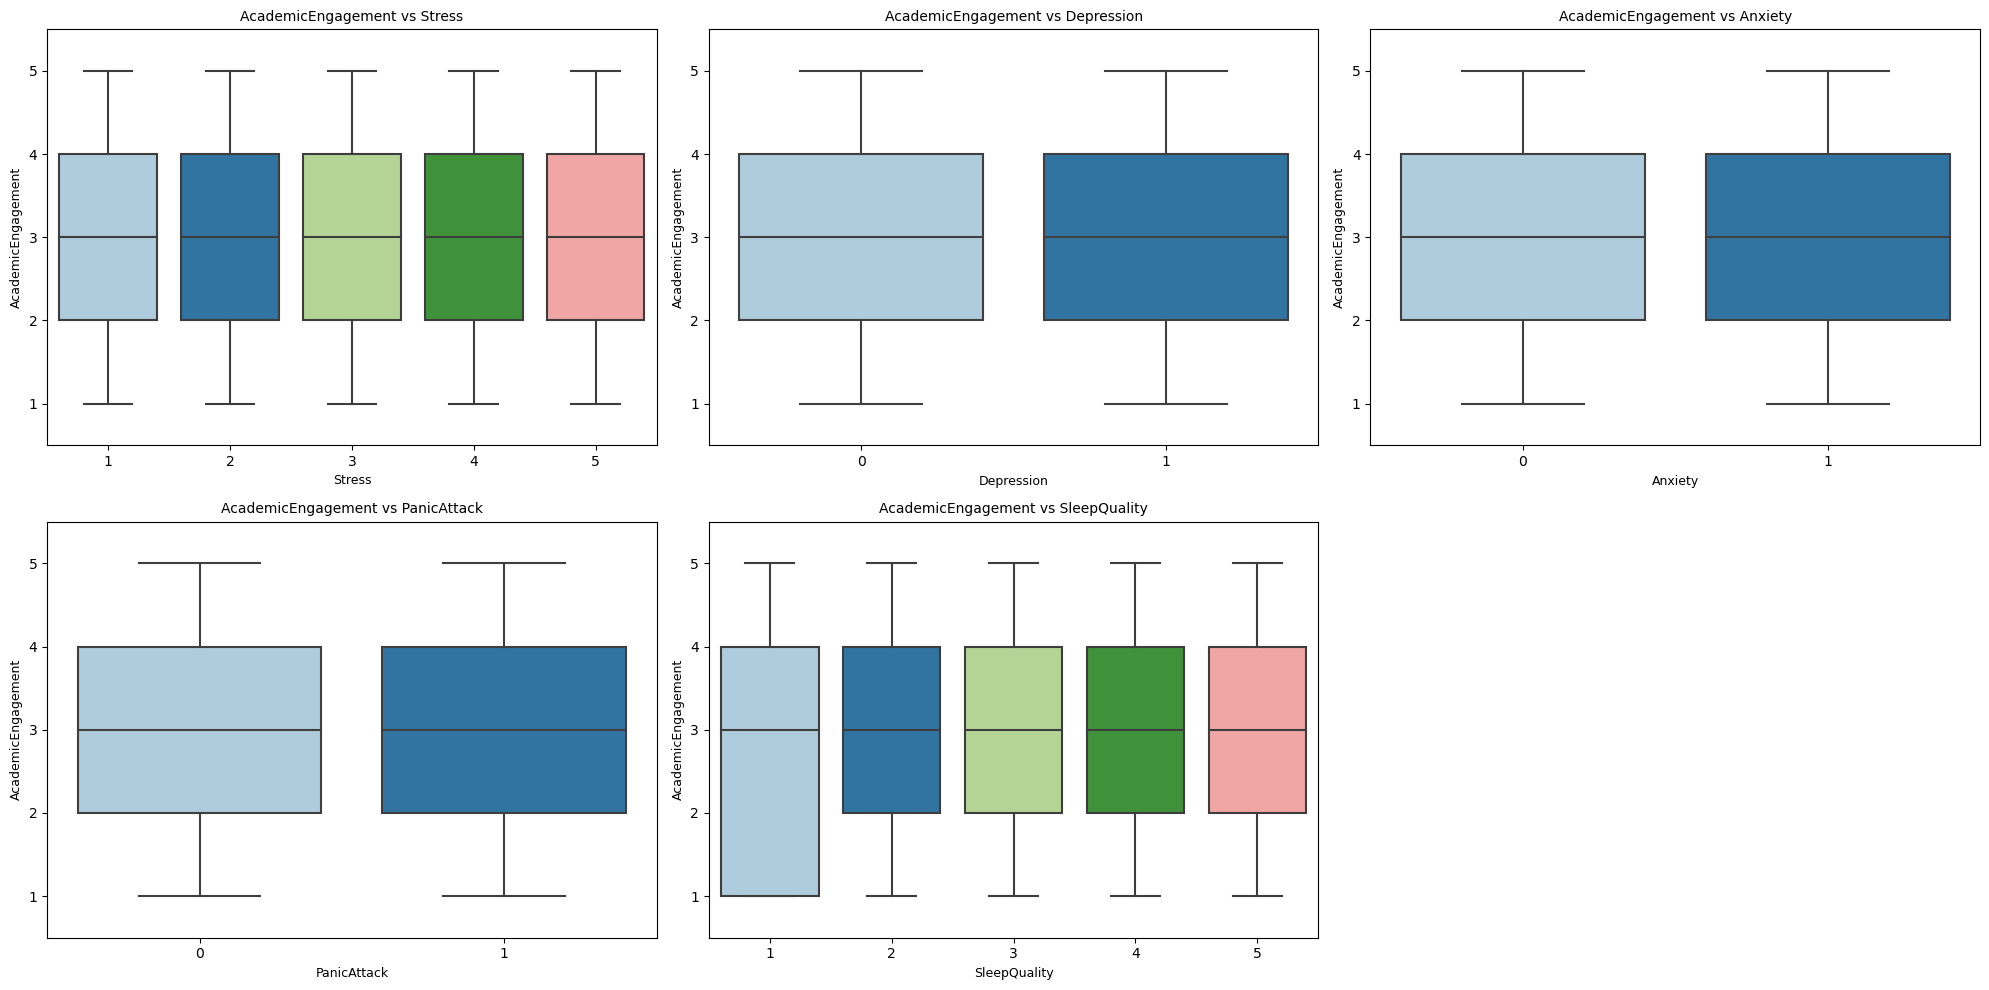

In [6]:
plt.figure(figsize=(20, 10))
for i, column in enumerate(mental_health_columns):
    plt.subplot(len(mental_health_columns) // num_cols + 1, num_cols, i + 1)
    sns.boxplot(data=df, x=column, y='AcademicEngagement', palette='Paired')
    plt.title(f'AcademicEngagement vs {column}', fontsize=10)
    plt.xlabel(column, fontsize=9)
    plt.ylabel('AcademicEngagement', fontsize=9)
    plt.ylim(df['AcademicEngagement'].min() - 0.5, df['AcademicEngagement'].max() + 0.5)
plt.tight_layout()
plt.show()

#### Some of the general observations from these histograms were: <br>
1. Academic Engagement really didn't appear to indicate any clear relation to the Mental health constraints. <br>
2. People with medium (3/5) sleep quality had more study hours and inherently higher GPAs. <br>
3. People that studied more reported more depression and panic attacks yet, less anxiety. <br>
4. Individuals with Mental Health issues appeared to perform better academically (GPA). <br>
5. Stress did not seem to play nearly as big a role as I expected, no correlation really showed, student performance is not inherently dependent on Stress levels possibly meaning that students are stressed out regardless.

### K-Means Clustering Analysis (Non-Supervised Learning)
The K-Means clustering algorithm was applied with PCA for dimensionality reduction to identify patterns and group students into 4 distinct clusters (Cluster 0, 1, 2, and 3). Each cluster reveals unique characteristics related to GPA, study habits, academic engagement, stress, and mental health indicators such as depression and anxiety.

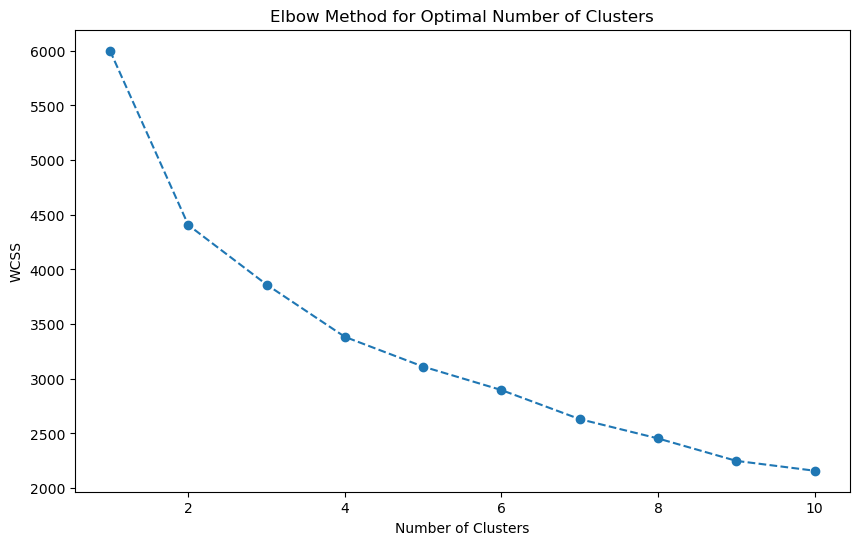

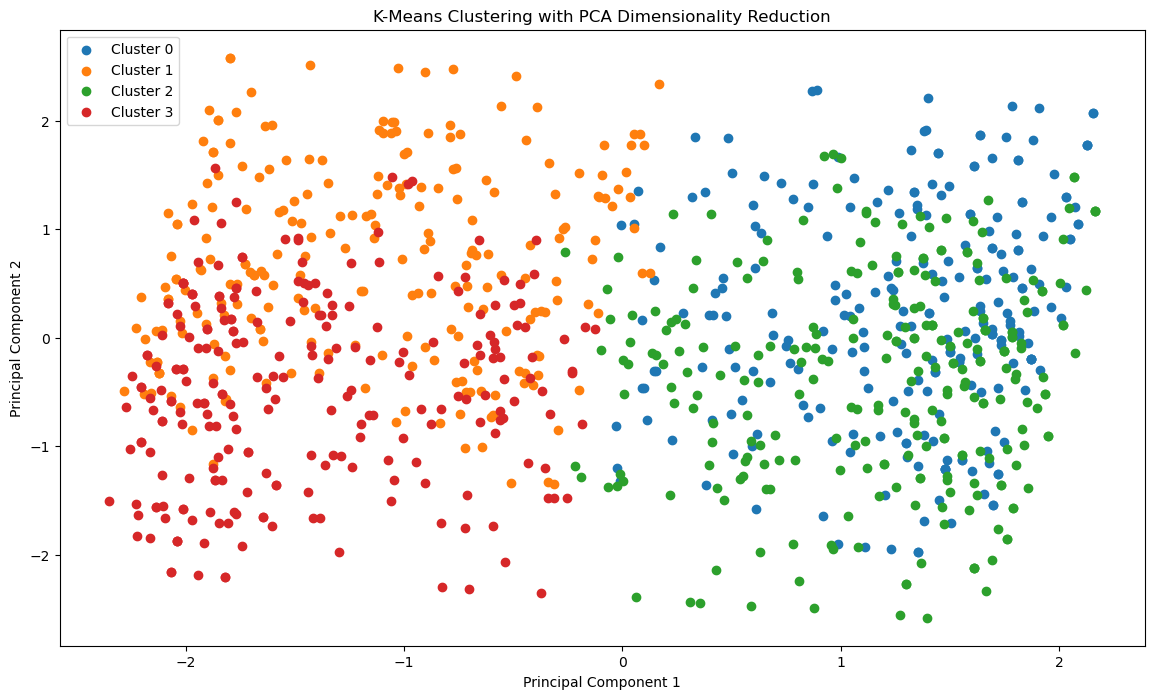


Cluster 0:
GPA                    3.8538
StudyHoursPerWeek     14.9880
AcademicEngagement     3.2880
Stress                 3.1000
Depression             0.0000
Anxiety                0.4360
dtype: float64

Cluster 1:
GPA                   2.448458
StudyHoursPerWeek     4.895833
AcademicEngagement    3.070833
Stress                3.054167
Depression            0.483333
Anxiety               1.000000
dtype: float64

Cluster 2:
GPA                    3.828302
StudyHoursPerWeek     13.943396
AcademicEngagement     3.143396
Stress                 3.113208
Depression             1.000000
Anxiety                0.471698
dtype: float64

Cluster 3:
GPA                   2.273265
StudyHoursPerWeek     4.608163
AcademicEngagement    2.706122
Stress                2.906122
Depression            0.416327
Anxiety               0.000000
dtype: float64
Silhouette Score:  0.21467004249523217


In [7]:
columns_for_clustering = ['GPA', 'StudyHoursPerWeek', 'AcademicEngagement', 'Stress', 'Depression', 'Anxiety']
data = df[columns_for_clustering]

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

#Elbow Curve graph
wcss = []
for i in range(1, 11):  # Test 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(data_scaled)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(10, 6)) #plot it
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

optimal_clusters = 4 #What I decided on after the Elbow Method graph
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(data_scaled)

df['Cluster'] = clusters

pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)

plt.figure(figsize=(14, 8))
for cluster in range(optimal_clusters):
    plt.scatter(data_pca[clusters == cluster, 0], 
                data_pca[clusters == cluster, 1], 
                label=f'Cluster {cluster}')
plt.title('K-Means Clustering with PCA Dimensionality Reduction')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

for cluster in range(optimal_clusters):
    print(f"\nCluster {cluster}:")
    print(df[df['Cluster'] == cluster][columns_for_clustering].mean())

sil_score = silhouette_score(data_scaled, clusters)
print('Silhouette Score: ', sil_score)


#### What does each cluster mean?
- Cluster 0 represents students who excel academically, study consistently, and report minimal depression. While their stress is moderate, their higher GPA and engagement suggest they manage their workload effectively.<br>
- Cluster 1 includes students struggling the most academically, with low GPA, minimal study hours, and the highest levels of anxiety and depression. This group appears to require immediate support in mental health interventions and academic counseling.<br>
- Cluster 2 represents students who maintain a good GPA and consistent study hours. However, the presence of depression at a significant level indicates that while their performance is stable, mental health struggles persist.<br>
- Cluster 3 students report the lowest academic engagement, which is reflected in their lower GPA and study hours. Although depression and anxiety are not prominent here, high stress is still reported, suggesting this group may struggle with motivation or external pressures. <br>


#### What else is worth noting?
- The Silhouette Score of ~ .21 shows some separation between clusters meaning that while you could definitely see some ways to group the clusters, there were still a lot of overlapping features. <br>
- Students resonating with Cluster 1 are a target group for prioritizing mental health resources <br>
- Students with the study habits similar to Cluster 3 will probably need more attention in terms of academic performace. <br>
- Even highly skilled students like those relative to Cluster 2 can still need mental health support.

### Random Forest Model
As a form of Supervised Machine learning, I went with a Random Forest model for its ability to handle imbalanced data, provide interpretable insights (feature importance), and effectively capture complex relationships in the data. These qualities align well with the project's goal of predicting mental illness among students and identifying the key factors driving those predictions.

In [8]:
#Students with Mental Health Issues
df['HasMentalIllness'] = ((df['Stress'] == 5) | (df['Anxiety'] == 1) | 
                          (df['Depression'] == 1) | (df['PanicAttack'] == 1)).astype(int)

#Features and Target var
features = ['Gender', 'Age', 'Course', 'YearOfStudy', 'GPA', 'StudyHoursPerWeek', 'AcademicEngagement']
X = df[features].copy()  # Use .copy() to avoid SettingWithCopyWarning
y = df['HasMentalIllness']

#Encoder
encoder = LabelEncoder()
X['Gender'] = encoder.fit_transform(X['Gender'])
X['Course'] = encoder.fit_transform(X['Course'])

#Splitting Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler()
for col in ['Age', 'GPA', 'StudyHoursPerWeek', 'AcademicEngagement']:
    X_train[col] = scaler.fit_transform(X_train[[col]])  # Scale training data
    X_test[col] = scaler.transform(X_test[[col]])  # Scale test data using same scaler

#Random Forest
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

#Scores
print("Random Forest Results:")
print("Accuracy:", accuracy_score(y_test, rf_preds))
print("Precision:", precision_score(y_test, rf_preds))
print("Recall:", recall_score(y_test, rf_preds))
print("F1-Score:", f1_score(y_test, rf_preds))
print("\nClassification Report:\n", classification_report(y_test, rf_preds))

Random Forest Results:
Accuracy: 0.8766666666666667
Precision: 0.8787878787878788
Recall: 0.9961832061068703
F1-Score: 0.9338103756708408

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.05      0.10        38
           1       0.88      1.00      0.93       262

    accuracy                           0.88       300
   macro avg       0.77      0.52      0.52       300
weighted avg       0.85      0.88      0.83       300



The RF Model is highly effective at detecting students who may need mental health support (Class 1), but it struggles with identifying students who do not. For use in a real-world scenario, the high recall for identifying at-risk students makes it a useful tool for early intervention, but efforts to reduce false positives should be prioritized to ensure resources are appropriately allocated.

### Artificial Neural Network (ANN) Model
As another form of Supervised Machine learning, I opted for the ANN Model for non-linear interactions, adaptability to resample data using SMOTE (how I avoided over sampling) and more improved predictive power as it's a Neural newtwork with a deep learning approach.

In [9]:
#To avoid over sampling
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

#ANN
history = model.fit(
    X_train_resampled, y_train_resampled,
        epochs=46, batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1,
    class_weight={0: 1, 1: len(y_train_resampled) / sum(y_train_resampled == 1)}
)

#Scores
ann_preds = (model.predict(X_test) > 0.5).astype(int)
print("\nANN Results:")
print("Accuracy:", accuracy_score(y_test, ann_preds))
print("Precision:", precision_score(y_test, ann_preds))
print("Recall:", recall_score(y_test, ann_preds))
print("F1-Score:", f1_score(y_test, ann_preds))
print("\nClassification Report:\n", classification_report(y_test, ann_preds))


Epoch 1/46
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4913 - loss: 1.4131 - val_accuracy: 0.8733 - val_loss: 0.4764
Epoch 2/46
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5217 - loss: 1.0949 - val_accuracy: 0.8733 - val_loss: 0.5148
Epoch 3/46
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5125 - loss: 1.0121 - val_accuracy: 0.8733 - val_loss: 0.5751
Epoch 4/46
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5441 - loss: 0.9953 - val_accuracy: 0.8733 - val_loss: 0.5360
Epoch 5/46
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5119 - loss: 0.9686 - val_accuracy: 0.8733 - val_loss: 0.5247
Epoch 6/46
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5314 - loss: 0.9408 - val_accuracy: 0.8733 - val_loss: 0.5206
Epoch 7/46
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5043 - loss: 0.9544 - val_accuracy: 0.8733 - val_loss: 0.5268
Epoch 8/46
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5456 - loss: 0.9533 - val_accuracy: 0.8700 - val_loss:

The ANN Model results are similar to the RF Model. It's highly effective for identifying students who may require mental health support (Class 1), achieving strong precision and recall for this group. However, the model struggles to correctly classify students without mental illness, which could lead to inefficient allocation of resources. Future improvements should focus on addressing class imbalance and enhancing the model's ability to identify Class 0 while maintaining its strong performance for Class 1.

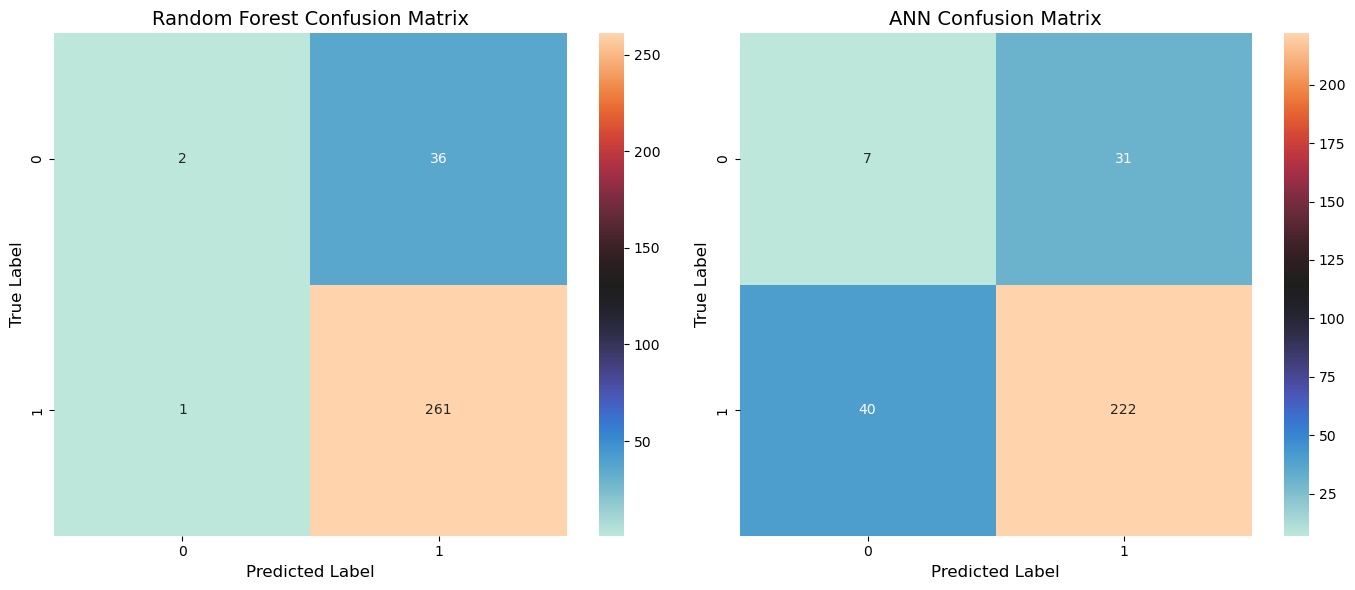

In [10]:
preds = [rf_preds, ann_preds]
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes = axes.flatten()

titles = ['Random Forest Confusion Matrix', 'ANN Confusion Matrix']
for i, (pred,ax) in enumerate(zip(preds,axes)):
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='icefire', ax = ax)
    ax.set_title(titles[i], fontsize=14)
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    
plt.tight_layout()
plt.show()

Overall, the Random Forest Model was a more accurate model simply based on how well at predicted individuals without any mental health contraints which the ANN Model did not do nearly as well.

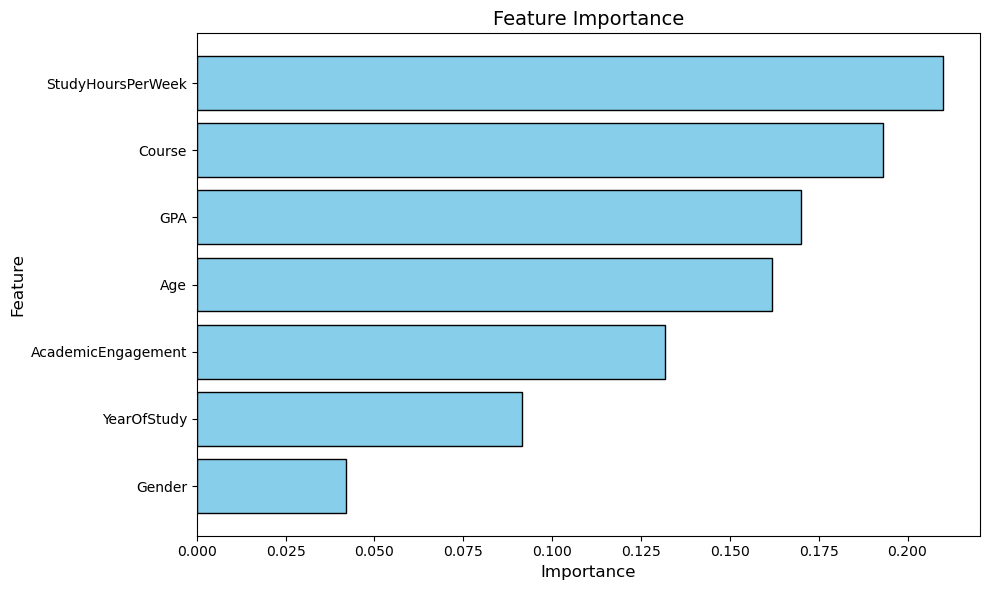

In [11]:
#Features
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue', edgecolor='black')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance', fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.tight_layout()
plt.show()

In [12]:
course_mental_illness = df.groupby('Course')['HasMentalIllness'].mean().sort_values(ascending=False)
top_courses = course_mental_illness.head(5)
print("Top Courses Resulting in Mental Illness:")
print(top_courses)

course_total_mental_illness = df[df['HasMentalIllness'] == 1].groupby('Course')['HasMentalIllness'].count().sort_values(ascending=False)
top_courses = course_total_mental_illness.head(5)
print("Total Number of Students Reporting Mental Illness by Course:")
print(top_courses)

# Proportion of students with mental illness per year of study
year_mental_illness = df.groupby('YearOfStudy')['HasMentalIllness'].mean().sort_values(ascending=False)
print("\nMental Illness Proportion by Year of Study:")
print(year_mental_illness)

# Proportion of students with mental illness by gender
gender_mental_illness = df.groupby('Gender')['HasMentalIllness'].mean().sort_values(ascending=False)
print("\nMental Illness Proportion by Gender:")
print(gender_mental_illness)

Top Courses Resulting in Mental Illness:
Course
Mathematics                  1.000000
Pharmacy                     1.000000
Health Studies               1.000000
English (Second Language)    1.000000
Pychology                    0.941176
Name: HasMentalIllness, dtype: float64
Total Number of Students Reporting Mental Illness by Course:
Course
Engineering          243
Computer Science     151
Religious Studies     96
IT                    92
Human Sciences        30
Name: HasMentalIllness, dtype: int64

Mental Illness Proportion by Year of Study:
YearOfStudy
2    0.894161
4    0.878378
1    0.866505
3    0.854167
Name: HasMentalIllness, dtype: float64

Mental Illness Proportion by Gender:
Gender
Male      0.875000
Female    0.871053
Name: HasMentalIllness, dtype: float64


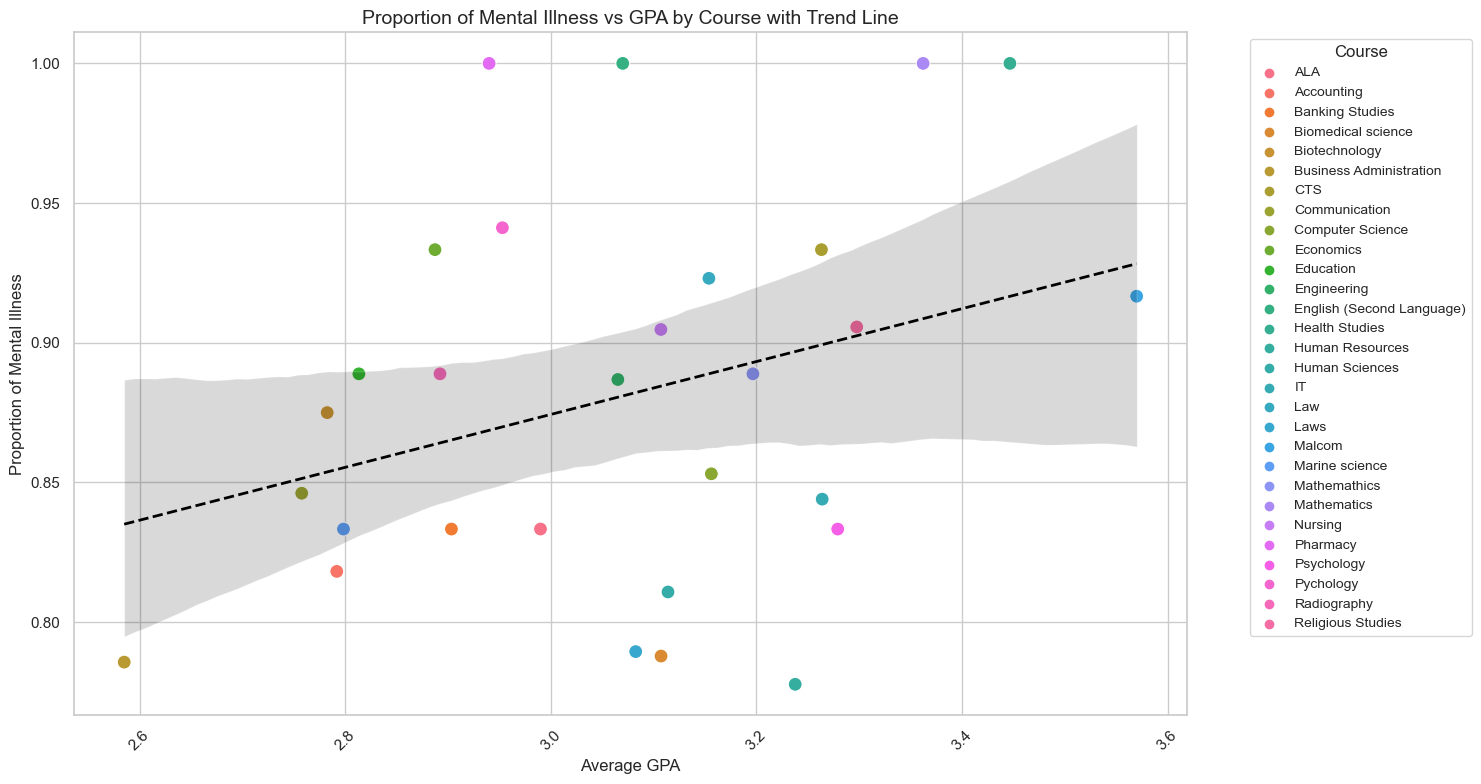

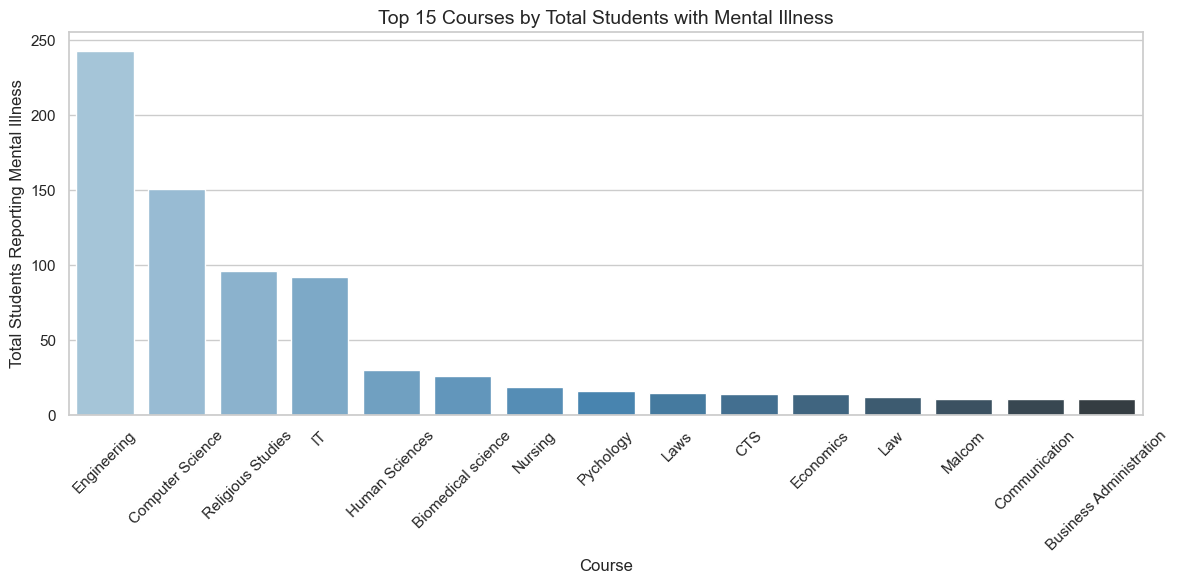

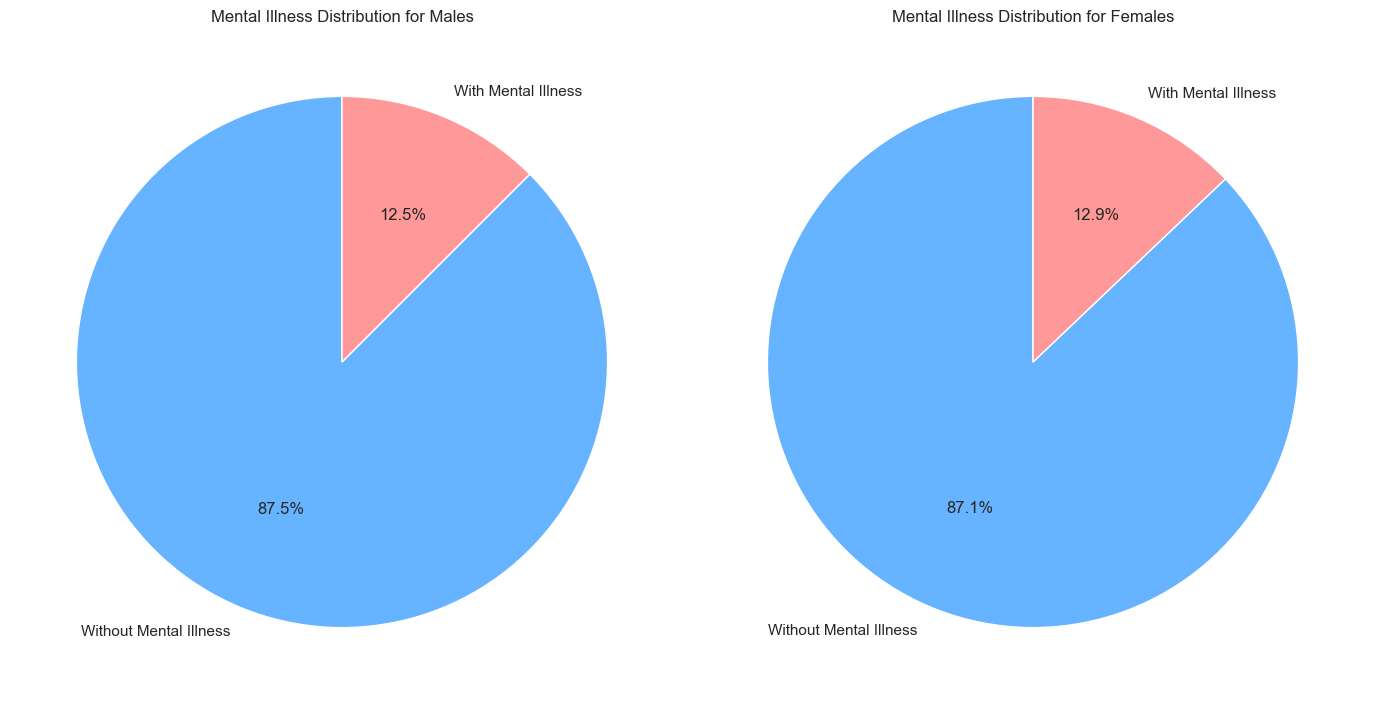

In [13]:
sns.set(style="whitegrid", palette="muted")

#MH vs GPA by Course
plt.figure(figsize=(15, 8))
course_gpa = df.groupby('Course').agg({'HasMentalIllness': 'mean', 'GPA': 'mean'}).reset_index()
scatter = sns.scatterplot(
    data=course_gpa, 
    x='GPA', 
    y='HasMentalIllness', 
    hue='Course', 
    s=100, 
    legend='full'
)
sns.regplot(
    data=course_gpa, 
    x='GPA', 
    y='HasMentalIllness', 
    scatter=False,  # Avoid double points
    color='black', 
    line_kws={"linestyle": "--", "linewidth": 2},  # Dashed trend line
)
plt.title("Proportion of Mental Illness vs GPA by Course with Trend Line", fontsize=14)
plt.xlabel("Average GPA")
plt.ylabel("Proportion of Mental Illness")
plt.xticks(rotation=45)
plt.legend(title='Course', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

#Freq of MH by course
plt.figure(figsize=(12, 6))
course_total_mental_illness = (
    df[df['HasMentalIllness'] == 1]
    .groupby('Course')['HasMentalIllness']
    .count()
    .reset_index()
    .sort_values(by='HasMentalIllness', ascending=False)
    .head(15)#just 15 courses to avoid overlapping
)
sns.barplot(data=course_total_mental_illness, x='Course', y='HasMentalIllness', palette='Blues_d')
plt.title("Top 15 Courses by Total Students with Mental Illness", fontsize=14)
plt.ylabel("Total Students Reporting Mental Illness")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Gender Charts
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

male_data = df[df['Gender'] == 'Male']['HasMentalIllness'].value_counts()
axes[0].pie(male_data, labels=['Without Mental Illness', 'With Mental Illness'], autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
axes[0].set_title("Mental Illness Distribution for Males")

female_data = df[df['Gender'] == 'Female']['HasMentalIllness'].value_counts()
axes[1].pie(female_data, labels=['Without Mental Illness', 'With Mental Illness'], autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
axes[1].set_title("Mental Illness Distribution for Females")

plt.tight_layout()
plt.show()

### Conclusions Drawn
The Random Forest Model ended up being a decent model at predicting student mental health based simply upon their demographic and student coursework details. It was interesting using the dataset that I picked as it depicted an overwhelming number of students actually suffering from mental health issues. I was impressed at the accuracy that the model showed despite the fact that our K-Mean clustering analytics and brief exploratory analysis had mixed results almost indicating no relationship shown between academics and mental health which was initially worrying. <br>
Most of the data I analyzed outside of the models actually reflected high amounts of anxiety, stress, and depression when paired with high GPA's and studying hours -- which is why it's very important for universities to promote Mental well-beings for their high-performing students.

### Implications, Limitations, and Future Developments
As of right now, the model merely predicts whether or not a student has a mental illness - in an ideal world this would also identify what the mental illness is. That would be not only be a way more impressive predictor, but would also avoid over sampling to the degree that it has and also help universities allocate the right resources to the appropriate students.